## knn算法

### 一.手写算法

In [1]:
# 导入相关模块
# 鸢尾花数据集的处理
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.utils import shuffle

iris = datasets.load_iris()                             # 导入sklearn iris数据集
X, y = shuffle(iris.data, iris.target, random_state=13) # 打乱数据后的数据与标签
X = X.astype(np.float32)                                # 数据转换为float32格式
offset = int(X.shape[0] * 0.7)                          # 训练集与测试集的简单划分，训练-测试比例为7：3
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]
y_train = y_train.reshape((-1,1))# 将标签转换为竖向量
y_test = y_test.reshape((-1,1))

# 打印训练集和测试集大小
# 共150条记录，训练集测试集只比为7:3
# 105条训练数据，45条测试数据。4个属性维度，1个类别标签
print('X_train=', X_train.shape)
print('X_test=', X_test.shape)
print('y_train=', y_train.shape)
print('y_test=', y_test.shape)

X_train= (105, 4)
X_test= (45, 4)
y_train= (105, 1)
y_test= (45, 1)


##### 1.定义欧氏距离
输入：  
X：测试样本实例矩阵  
X_train：训练样本实例矩阵  

输出：  
dists：欧式距离  

In [2]:
### 定义欧氏距离
def compute_distances(X, X_train):
    num_test = X.shape[0]                          # 测试实例样本量
    num_train = X_train.shape[0]                   # 训练实例样本量
    dists = np.zeros((num_test, num_train))        # 基于训练和测试维度的欧氏距离初始化
    M = np.dot(X, X_train.T)                       # 测试样本与训练样本的矩阵点乘
    te = np.square(X).sum(axis=1)                  # 测试样本矩阵平方
    tr = np.square(X_train).sum(axis=1)            # 训练样本矩阵平方
    dists = np.sqrt(-2 * M + tr + np.matrix(te).T) # 计算欧式距离
    return dists

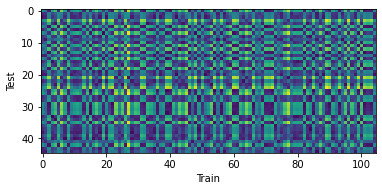

In [3]:
# 绘图
dists = compute_distances(X_test, X_train) # dists的大小45*105
# print(dists)
# print(dists.shape)
plt.imshow(dists, interpolation='none')
plt.xlabel('Train')
plt.ylabel('Test')
plt.show()

##### 2.定义预测函数
输入：  
y_train：训练集标签  
dists：测试集与训练集之间的欧氏距离矩阵  
k：k值  

输出：  
y_pred：测试集预测结果  

In [4]:
### 定义预测函数
def predict_labels(y_train, dists, k=1):
    num_test = dists.shape[0]   # 测试样本量
    y_pred = np.zeros(num_test) # 初始化测试集预测结果
    for i in range(num_test):   # 遍历
        closest_y = []    # 初始化最近邻列表
        # 按欧氏距离矩阵排序后取索引，并用训练集标签按排序后的索引取值
        # 最后拉平列表
        # 注意np.argsort函数的用法
        labels = y_train[np.argsort(dists[i, :])].flatten()
        closest_y = labels[0:k] # 取最近的k个值
        # 对最近的k个值进行计数统计
        # 这里注意collections模块中的计数器Counter的用法
        c = Counter(closest_y)
        y_pred[i] = c.most_common(1)[0][0] # 取计数最多的那一个类别
    return y_pred

In [5]:
# 预测并计算准确率
y_test_pred = predict_labels(y_train, dists, k=1) # 测试集预测结果
y_test_pred = y_test_pred.reshape((-1, 1))
num_correct = np.sum(y_test_pred == y_test)       # 找出预测正确的实例
accuracy = float(num_correct) / X_test.shape[0]   # 计算准确率
print('Got %d/%d correct=>accuracy:%f'% (num_correct, X_test.shape[0], accuracy))

Got 44/45 correct=>accuracy:0.977778


In [6]:
### 5折交叉验证
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100] # 候选k值
X_train_folds = []
y_train_folds = []
X_train_folds = np.array_split(X_train, num_folds) # 训练数据划分
y_train_folds = np.array_split(y_train, num_folds) # 训练标签划分
k_to_accuracies = {}
# 遍历所有候选k值
for k in k_choices:
    # 五折遍历    
    for fold in range(num_folds): 
        # 对传入的训练集单独划出一个验证集作为测试集
        validation_X_test = X_train_folds[fold]
        validation_y_test = y_train_folds[fold]
        temp_X_train = np.concatenate(X_train_folds[:fold] + X_train_folds[fold + 1:])
        temp_y_train = np.concatenate(y_train_folds[:fold] + y_train_folds[fold + 1:])       
        # 计算距离
        temp_dists = compute_distances(validation_X_test, temp_X_train)
        temp_y_test_pred = predict_labels(temp_y_train, temp_dists, k=k)
        temp_y_test_pred = temp_y_test_pred.reshape((-1, 1))       
        # 查看分类准确率
        num_correct = np.sum(temp_y_test_pred == validation_y_test)
        num_test = validation_X_test.shape[0]
        accuracy = float(num_correct) / num_test
        k_to_accuracies[k] = k_to_accuracies.get(k,[]) + [accuracy]

# 打印不同 k 值不同折数下的分类准确率
for k in sorted(k_to_accuracies):    
      for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.904762
k = 1, accuracy = 1.000000
k = 1, accuracy = 0.952381
k = 1, accuracy = 0.857143
k = 1, accuracy = 0.952381
k = 3, accuracy = 0.857143
k = 3, accuracy = 1.000000
k = 3, accuracy = 0.952381
k = 3, accuracy = 0.857143
k = 3, accuracy = 0.952381
k = 5, accuracy = 0.857143
k = 5, accuracy = 1.000000
k = 5, accuracy = 0.952381
k = 5, accuracy = 0.904762
k = 5, accuracy = 0.952381
k = 8, accuracy = 0.904762
k = 8, accuracy = 1.000000
k = 8, accuracy = 0.952381
k = 8, accuracy = 0.904762
k = 8, accuracy = 0.952381
k = 10, accuracy = 0.952381
k = 10, accuracy = 1.000000
k = 10, accuracy = 0.952381
k = 10, accuracy = 0.904762
k = 10, accuracy = 0.952381
k = 12, accuracy = 0.952381
k = 12, accuracy = 1.000000
k = 12, accuracy = 0.952381
k = 12, accuracy = 0.857143
k = 12, accuracy = 0.952381
k = 15, accuracy = 0.952381
k = 15, accuracy = 1.000000
k = 15, accuracy = 0.952381
k = 15, accuracy = 0.857143
k = 15, accuracy = 0.952381
k = 20, accuracy = 0.952381
k = 20, accu

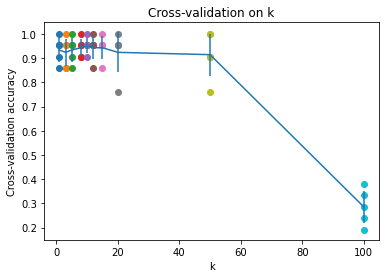

In [7]:
for k in k_choices: # 打印不同 k 值不同折数下的分类准确率
    accuracies = k_to_accuracies[k] # 取出第k个k值的分类准确率
    plt.scatter([k] * len(accuracies), accuracies)                                   # 绘制不同k值准确率的散点图
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())]) # 计算准确率均值并排序
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])   # 计算准确率标准差并排序
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)                       # 绘制有置信区间的误差棒图
plt.title('Cross-validation on k')       # 绘图标题
plt.xlabel('k')                          # x轴标签
plt.ylabel('Cross-validation accuracy')  # y轴标签
plt.show()

### 二.使用sklearn

In [8]:
from sklearn.neighbors import KNeighborsClassifier # 导入KneighborsClassifier模块
neigh = KNeighborsClassifier(n_neighbors=10)    # 创建k近邻实例
neigh.fit(X_train, y_train)                     # k近邻模型拟合
y_pred = neigh.predict(X_test)                  # k近邻模型预测
y_pred = y_pred.reshape((-1, 1))                # 预测结果数组重塑
num_correct = np.sum(y_pred == y_test)          # 统计预测正确的个数
accuracy = float(num_correct) / X_test.shape[0] # 计算准确率
print('Got %d / %d correct => accuracy: %f' % (num_correct, X_test.shape[0], accuracy))

Got 44 / 45 correct => accuracy: 0.977778


D:\Anacondafolds\installfiles\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
